In [104]:
# clears any old variables, as we're probably running the whole notebook.
%reset -f

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rng

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Softmax

This implements a multi-class neuron. Let $X$ be a $D \times N$ matrix of data, where $N$ is the number of data points and $D$ is the dimension of each instance. So each column of $X$ is a data point.

We'll ignore biases for now, so let $W$ be a $C \times D$ matrix of data that represents the weights of the stacked neurons, where $C$ is the number of classes. So each row of $W$ is one neuron's weights vector.

Lastly, let $\vec y$ be an $N$-long vector of the correct class label for each data point, that is, a number between $1$ and $C$.

The loss of a the $i$-th data point is: $$
  L_i = - \log \left( \frac{\exp(W_{y_i} \vec x_i ) }{\sum_j \exp(W_j \vec x_i)} \right)
$$
And we'll take the loss on the data as a whole to be the average loss over all data points: $$
  L = \frac1N \sum_i L_i
$$

With a bit of work, we end up with the following gradient for each _row_ (i.e. weight vector) of $W$. $$
  \frac{\partial}{\partial w_c} L = - \frac1N \sum_i \mathbb{1}(y_i = c) - \frac{\exp(W_c \vec x_i)}{\sum_j \exp(W_j \vec x_i)} \vec x_i
$$

Where $\mathbb{1}(X)$ is $1$ if $X$ is true and $0$ otherwise.

We want to collapse this down to proper vectorised form though, which means computing the gradient of the entire matrix at once (instead of in rows). I've convinced myself that the formula comes out pretty much the same, so hopefully we're done.

In [105]:
def softmax_loss(W, X, y):
    '''
      Computes the softmax loss and its gradient for given weights,
      data, and correct class labels.
      
      Let C be the number of classes, N be the number of data points,
      and D be the dimension of each data point.
      
      Inputs:
      - W: C x D array of weights.
      - X: D x N array of data. Each data point is a column.
      - y: 1 x N array with the correct class of each data point.
      Outputs:
      - loss: the softmax loss.
      - grad: the gradient matrix W (which is also C x D).
    '''
    
    assert len(X.shape) == 2
    assert len(W.shape) == 2
    assert len(y.shape) == 1
    assert X.shape[0] == W.shape[1]
    assert X.shape[1] == y.shape[0]
    # this is important as we need to index with y.
    assert y.dtype == int
    
    N = X.shape[1]
    C = W.shape[0]
    D = X.shape[0]
    
    WX = W.dot(X)
    
    # for numeric stability, we remove the max from each weight vector
    # (i.e. row of WX). this doesn't change the output.
    exp_WX = np.exp(WX - WX.max(axis=0))
    
    # compute the normalisers, i.e. the denominator of the softmax.
    Z = exp_WX.sum(axis=0)
    
    # compute the loss itself
    ns = np.arange(N, dtype=int)
    loss = -np.sum(np.log( exp_WX[y[ns], ns]/Z )) / N
    
    # find the gradient matrix. the correct_classes matrix
    # collapses the two cases (the current class is the correct
    # one for this data point, or the incorrect one).
    correct_classes = np.zeros(exp_WX.shape)
    correct_classes[y, ns] = 1
    grad = - (correct_classes -  exp_WX/Z).dot(X.T) / N
    
    return loss, grad   

# Gradient Descent

That's the loss, now we need the machinery around it. Let's do normal (not stochastic) gradient descent. I have no idea when to stop this thing, so we'll stop when the L2 norm squared of the whole matrix is below some value.

In [119]:
def softmax(X, y, C, eta=1, threshold=0.001):
    '''
      Learns a good weights matrix for the given data.
      
      Inputs:
      - X: D x N array of data. Each data point is a column.
      - y: 1 x N array with the correct class of each data point.
      - C: scalar, the number of classes.
      - eta: scalar, learning rate.
      Outputs:
      - W: C x D weights matrix.
    '''
    
    D, N = X.shape
    
    # randomly initialise weights.
    W = rng.normal( size=C*D ).reshape(C, D)

    while True:
        _, grad = softmax_loss(W, X, y)
        W += - eta * grad
        
        norm = np.sum(grad * grad)
        if norm < threshold:
            break
    
    return W

def classify(W, X):
    '''
    Classifies the given data with the given weights.
    
    Inputs:
    - W: C x D array of weights.
    - X: D x N array of data.
    Outputs:
    - y: 1 x N array of the predicted class of each data point.
    '''
    
    return (W.dot(X)).argmax(axis=0)

# Experiments

Let's make up some fake data and throw the softmax at it. We'll do something really simple, 3 (probably) linearly seperable classes on the plane.

The picture shows each of the classes of training data in a different colour, and has the test data in white diamonds on top of that (it's fairly clear which class each test data point comes from). Looks like it does the job.

W = 
[[-0.34093979 -0.86344009  2.09072864]
 [ 0.40813903  0.0815034  -1.21687329]
 [ 0.46674818 -2.26881131 -2.5803415 ]]

ACCURACY = 1.0


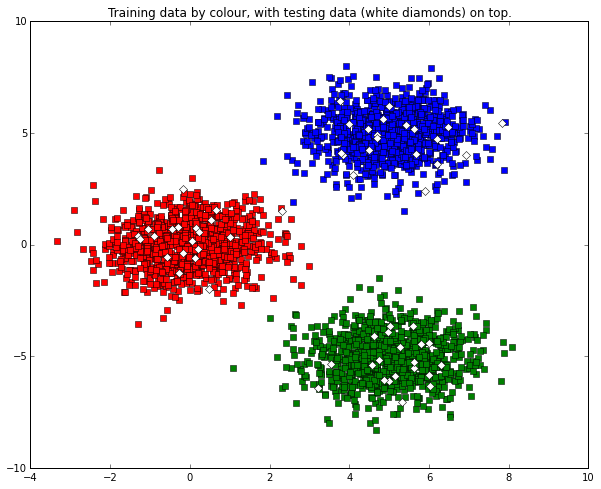

In [120]:
def make_data(spc:'samples per class'):
    means = [(0,0), (5, 5), (5, -5)]

    X = np.zeros( (2, 3 * spc) )
    y = np.zeros(3 * spc, dtype=int)
    
    for i in range(len(means)):
        # for some reason, size can't be (2, spc)
        X[:, i*spc : (i+1)*spc] = rng.normal(loc=means[i], size=(spc,2)).T
        y[i*spc : (i+1)*spc] = i
        
    # for the bias trick, add ones to the end of each data point.
    X = np.vstack(( X, np.ones(3*spc) ))
        
    return X, y

# make some training data.
spc = 1000 # samples per class
X, y = make_data(spc)

# plot the data, colour coded by class.
styles = ['rs', 'bs', 'gs']
plt.title('Training data by colour, with testing data (white diamonds) on top.')
for i in range(3):
    plt.plot(X[0][i*spc:(i+1)*spc],X[1][i*spc:(i+1)*spc], styles[i])

# train the classifier.
W = softmax(X, y, 3)
print('W = ')
print(W)

# make some test data.
spc = 20
te_X, te_y = make_data(spc)

# run the classifier.
prediction = classify(W, te_X)

# results.
misses = np.where(prediction != te_y)[0].size
print('\nACCURACY =', 1 - (misses / (3*spc)) )

# plot the testing data
for i in range(3):
    plt.plot(te_X[0][i*spc:(i+1)*spc],te_X[1][i*spc:(i+1)*spc], 'wD')